In [1]:
from pony.orm import *; set_sql_debug(True)
import pony.orm as pny
import pandas as pd
from random import randrange, uniform
import os
import sys
import sqlite3
import datetime
from faker import Faker; fake = Faker()

In [2]:
def create_connection(db_file, rewrite=False):
    """ create a database connection to an SQLite database """
    connection = None
    try:
        if rewrite: os.remove(db_file)
        connection = sqlite3.connect(db_file)
        cursor = connection.cursor()
    except (Error, FileNotFoundError) as e:
        print(e)
    else:
        return (connection, cursor)
    
def ER_draw(db_file):
    from eralchemy import render_er
    from IPython.display import Image, display
    
    render_er(f"sqlite:///{db_file}", 'erd_from_sqlite.png')
    display(Image(filename='erd_from_sqlite.png'))
    
def execute_commands(sstring, SQL_queries_exist=False):
#   execute_commands('''sql_string''')
    if SQL_queries_exist:
        sql_string = sstring.replace("\n", "").replace('AUTO_INCREMENT', '').split(";")
        tmp = [curs.execute(string) for string in sql_string if len(string)>2]
        conn.commit()
        return False
    else: 
        return True
    
def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)

def attype(ent, attr, tot_len, i):
    attr_type = getattr(ent, attr).py_type
#     print(getattr(ent, attr))
    if attr in ent._pk_paths_:
        if attr_type in (str, unicode, LongStr, LongUnicode):
            return f"{ent.__name__}_{attr}{i+1}"
    else:
        if attr_type in (str, unicode, LongStr, LongUnicode):
            return f"{attr}_{i+1}"
#       elif attr_type in (IntArray, StrArray, FloatArray): Only possibility I did not take into account
        elif attr_type in (datetime.datetime, datetime.date ,datetime.time ,datetime.timedelta):
            return fake.date_time_between(start_date='-1y', end_date='now')
        elif attr_type == float:
            return round(uniform(-tot_len, tot_len*2), 2)
        elif attr_type == int:
            return randrange(-tot_len, tot_len*2)
        elif attr_type == bool:
            return fake.pybool()
        else:
            try:
                if attr_type._pk_.py_type in (str, unicode, LongStr, LongUnicode):
                    key =  f"{attr_type.__name__}_{attr_type._pk_.column}{randrange(1, tot_len+1)}"
                elif attr_type._pk_.py_type == int:
                    key = randrange(1, tot_len+1)
                return key
            except Exception as inst:
                print(inst)
                
def sql_present(squery=None, ent_name=None, entity_present=False):
    if entity_present and ent_name:
        return pd.read_sql_query(f"SELECT * FROM {ent_name}", conn).rename_axis(ent_name, axis=1)
    else:
        return pd.read_sql_query(squery.replace("\n", "").split(";")[0], conn)
    
def fake_fillin(entities, num_of_values=5):
    """_Fill in fake data to db_"""

    entities = list(entities.keys())
    total_values = num_of_values
    for ent in entities:
        entity = str_to_class(ent)
        entity_keys = entity._columns_
        gen_vals = [tuple([str(attype(entity,attr,total_values,i)) for attr in entity_keys if not(attr in entity._pk_paths_ and getattr(entity, attr).py_type == int)]) for i in range(total_values)]

        sql = f"INSERT INTO {entity.__name__} {tuple(entity_keys[-len(gen_vals[0]):])} VALUES {tuple(['?']*len(gen_vals[0]))}".replace("'", "").replace(",)", ")")
        
        tmp = curs.executemany(sql, gen_vals)
    conn.commit()

In [3]:
'''_Sql query for db init_'''

squery = '''
CREATE TABLE Worker (
    WORKER_ID INT NOT NULL PRIMARY KEY AUTO_INCREMENT,
    FIRST_NAME CHAR(25),
    LAST_NAME CHAR(25),
    SALARY INT(15),
    JOINING_DATE DATETIME,
    DEPARTMENT CHAR(25)
);

INSERT INTO Worker 
    (WORKER_ID, FIRST_NAME, LAST_NAME, SALARY, JOINING_DATE, DEPARTMENT) VALUES
        (001, 'Monika', 'Arora', 100000, '14-02-20 09.00.00', 'HR'),
        (002, 'Niharika', 'Verma', 80000, '14-06-11 09.00.00', 'Admin'),
        (003, 'Vishal', 'Singhal', 300000, '14-02-20 09.00.00', 'HR'),
        (004, 'Amitabh', 'Singh', 500000, '14-02-20 09.00.00', 'Admin'),
        (005, 'Vivek', 'Bhati', 500000, '14-06-11 09.00.00', 'Admin'),
        (006, 'Vipul', 'Diwan', 200000, '14-06-11 09.00.00', 'Account'),
        (007, 'Satish', 'Kumar', 75000, '14-01-20 09.00.00', 'Account'),
        (008, 'Geetika', 'Chauhan', 90000, '14-04-11 09.00.00', 'Admin');

CREATE TABLE Bonus (
    WORKER_REF_ID INT,
    BONUS_AMOUNT INT(10),
    BONUS_DATE DATETIME,
    FOREIGN KEY (WORKER_REF_ID)
        REFERENCES Worker(WORKER_ID)
        ON DELETE CASCADE
);

INSERT INTO Bonus 
    (WORKER_REF_ID, BONUS_AMOUNT, BONUS_DATE) VALUES
        (001, 5000, '16-02-20'),
        (002, 3000, '16-06-11'),
        (003, 4000, '16-02-20'),
        (001, 4500, '16-02-20'),
        (002, 3500, '16-06-11');
CREATE TABLE Title (
    WORKER_REF_ID INT,
    WORKER_TITLE CHAR(25),
    AFFECTED_FROM DATETIME,
    FOREIGN KEY (WORKER_REF_ID)
        REFERENCES Worker(WORKER_ID)
        ON DELETE CASCADE
);

INSERT INTO Title 
    (WORKER_REF_ID, WORKER_TITLE, AFFECTED_FROM) VALUES
 (001, 'Manager', '2016-02-20 00:00:00'),
 (002, 'Executive', '2016-06-11 00:00:00'),
 (008, 'Executive', '2016-06-11 00:00:00'),
 (005, 'Manager', '2016-06-11 00:00:00'),
 (004, 'Asst. Manager', '2016-06-11 00:00:00'),
 (007, 'Executive', '2016-06-11 00:00:00'),
 (006, 'Lead', '2016-06-11 00:00:00'),
 (003, 'Lead', '2016-06-11 00:00:00');
 '''

'_Sql query for db init_'

In [4]:
db_file = 'test.db'
conn, curs = create_connection(db_file, rewrite=True)
## curs.close()
## conn.close()

db = Database()
#...............................................................ENTITIES...................................................................
class Worker(db.Entity):
#     _table_ = "enrollments"
    WORKER_ID = PrimaryKey(int)
    FIRST_NAME = Optional(str)
    LAST_NAME = Optional(str)
    SALARY = Optional(int)
    JOINING_DATE = Optional(datetime.datetime)
    DEPARTMENT = Optional(str)
    BONUSES = Set('Bonus', reverse="WORKER_REF_ID")
    TITLES = Set('Title', reverse="WORKER_REF_ID")
    
class Bonus(db.Entity):
    WORKER_REF_ID = Required(Worker, reverse="BONUSES")
    BONUS_AMOUNT = Optional(int)
    BONUS_DATE = Optional(datetime.datetime)   
        
class Title(db.Entity):
    WORKER_REF_ID = Required(Worker, reverse="TITLES")
    WORKER_TITLE = Optional(str)
    AFFECTED_FROM = Optional(datetime.datetime)
#__________________________________________________________________________________________________________________________________________

gen_fake_dat = execute_commands(squery, SQL_queries_exist=True)#<-<--<---<----<-----<------<---------------------------------------------<<

# db.bind(provider='sqlite', filename=':memory:')
db.bind(provider='sqlite', filename=f"{os.path.abspath(os.getcwd())}/{db_file}", create_db=True)
db.generate_mapping(create_tables=True, check_tables=gen_fake_dat)

if gen_fake_dat:
    fake_fillin(db.entities, 5)

GET NEW CONNECTION
RELEASE CONNECTION
GET CONNECTION FROM THE LOCAL POOL
PRAGMA foreign_keys = false
BEGIN IMMEDIATE TRANSACTION
CREATE INDEX "idx_bonus__worker_ref_id" ON "Bonus" ("WORKER_REF_ID")

CREATE INDEX "idx_title__worker_ref_id" ON "Title" ("WORKER_REF_ID")

COMMIT
PRAGMA foreign_keys = true
CLOSE CONNECTION


/home/chris/.local/lib/python3.8/site-packages/sqlalchemy/dialects/sqlite/base.py:1821: SAWarning: Could not instantiate type <class 'sqlalchemy.sql.sqltypes.INTEGER'> with reflected arguments ['10']; using no arguments.
  util.warn(
/home/chris/.local/lib/python3.8/site-packages/sqlalchemy/dialects/sqlite/base.py:1821: SAWarning: Could not instantiate type <class 'sqlalchemy.sql.sqltypes.INTEGER'> with reflected arguments ['15']; using no arguments.
  util.warn(


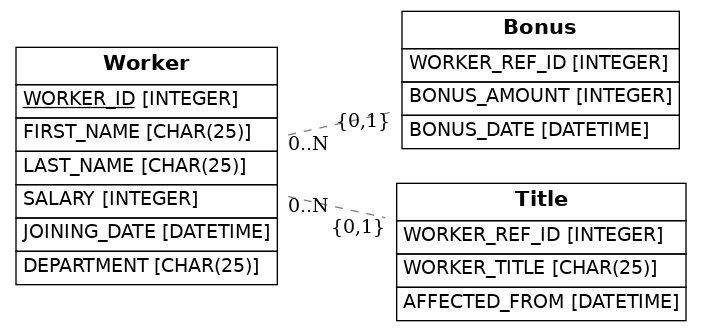

Worker,WORKER_ID,FIRST_NAME,LAST_NAME,SALARY,JOINING_DATE,DEPARTMENT
0,1,Monika,Arora,100000,14-02-20 09.00.00,HR
1,2,Niharika,Verma,80000,14-06-11 09.00.00,Admin
2,3,Vishal,Singhal,300000,14-02-20 09.00.00,HR
3,4,Amitabh,Singh,500000,14-02-20 09.00.00,Admin
4,5,Vivek,Bhati,500000,14-06-11 09.00.00,Admin
5,6,Vipul,Diwan,200000,14-06-11 09.00.00,Account
6,7,Satish,Kumar,75000,14-01-20 09.00.00,Account
7,8,Geetika,Chauhan,90000,14-04-11 09.00.00,Admin


Bonus,WORKER_REF_ID,BONUS_AMOUNT,BONUS_DATE
0,1,5000,16-02-20
1,2,3000,16-06-11
2,3,4000,16-02-20
3,1,4500,16-02-20
4,2,3500,16-06-11


Title,WORKER_REF_ID,WORKER_TITLE,AFFECTED_FROM
0,1,Manager,2016-02-20 00:00:00
1,2,Executive,2016-06-11 00:00:00
2,8,Executive,2016-06-11 00:00:00
3,5,Manager,2016-06-11 00:00:00
4,4,Asst. Manager,2016-06-11 00:00:00
5,7,Executive,2016-06-11 00:00:00
6,6,Lead,2016-06-11 00:00:00
7,3,Lead,2016-06-11 00:00:00


In [5]:
ER_draw(db_file)
for ent in list(db.entities.keys()):
    sql_present(ent_name=str_to_class(ent).__name__, entity_present=True)